# Basic Cleaning

The data set contains errant data points including:

 - duplicate data points
 - background noise: evidenced by signals recieved outside of opening hours
 - signals recieved outside the mall
 - signals suggesting unrealistic pedestrian speeds
 - signals not moving or relatively stationary: shop workers
 
In the analysis below, for demonstrative purpose, we show all results for the phonix mall. Equivalent results can be attained for the other two malls. 

In [2]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

import clean_data as cda

import warnings
warnings.filterwarnings('ignore')

## Import Data

In [3]:
COLUMNS_TO_IMPORT = ['mac_address', 'date_time', 'location', 'store_id', 'x', 'y']

shopper_df = pd.read_csv('../data/bag_mus_12-22-2016.csv', usecols=COLUMNS_TO_IMPORT)
shopper_df.date_time = shopper_df.date_time.astype('datetime64[ns]')

#hl_df = shopper_df[shopper_df['location'] == 'Home & Leisure']
#mm_df = shopper_df[shopper_df['location'] == 'Mall of Mauritius']
p_df = shopper_df[shopper_df['location'] == 'Phoenix Mall']

minimum = 10
speed = 3

# locations = [
#     {'name': 'home', 'df': hl_df, 'open_time': '09:30:00', 'close_time': '20:00:00'},
#     {'name': 'mauritius', 'df': mm_df, 'open_time': '09:30:00', 'close_time': '21:00:00'},
#     {'name': 'phoenix', 'df': p_df, 'open_time': '09:30:00', 'close_time': '18:00:00'}
# ]

## Removal of Duplicate Data Points

Occasionally there are points in the data set that are identical, there is no need to retain these. We remove them.

In [4]:
p_df = cda.remove_duplicates(p_df)

## Background Noise Removal

Below is a histogram showing the number of shoppers against time for one of the shopping malls. The non-zero count in the early hours of the morning before the shopping mall opens suggests these are false signals. We opt to remove all mac addresses associated with these out of hour signals.

Text(0,0.5,'Count of shoppers (no.)')

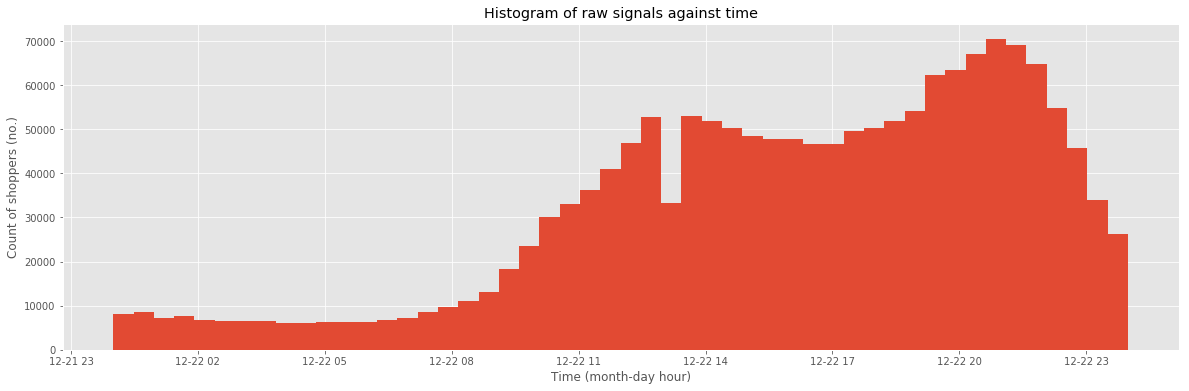

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
ax = p_df.date_time.hist(bins=50, ax=axes)
ax.set_title('Histogram of raw signals against time')
ax.set_xlabel('Time (month-day hour)')
ax.set_ylabel('Count of shoppers (no.)')

With these signals removed, the same plot seems more plausible:

Text(0,0.5,'Count of shoppers (no.)')

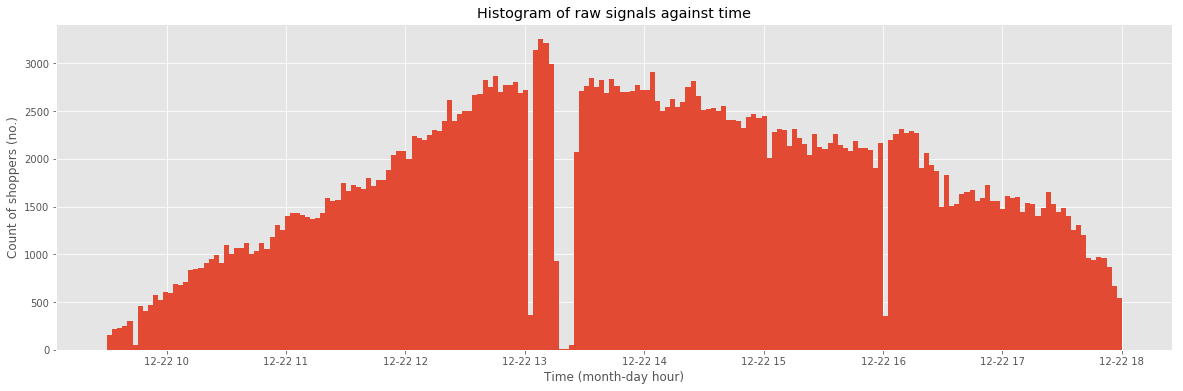

In [6]:
p_df = cda.remove_outside_hours(p_df, '09:30:00', '18:00:00')

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
ax = p_df.date_time.hist(bins=200, ax=axes)
ax.set_title('Histogram of raw signals against time')
ax.set_xlabel('Time (month-day hour)')
ax.set_ylabel('Count of shoppers (no.)')

## Unrealistic Pedestrain Speeds

Typical jogging speeds are around 3$ms^{-1}$. By grouping the dataset in terms of mac address and sorting by time, we can evaluate the change in euclidean distance between any two timestamps and subsequently estimate an average velocity for the mac address between each data point. We discard all mac addresses that contain velocities exceeding this jogging speed. 

nan 22540 [1.1141715789170272, 1.2128918329244807, 0.031932236469686445, 0.60133090710389925, 0.42801562892671352, 0.30253990682077025, 0.46562399602709564, 0.68756114055458939, 0.0, 0.62325223922447959, 0.85105829453528825, 1.4549652435143667, 0.7740029942683897, 0.81644529023687629, 1.1080759548784582, 0.74625558141235582, 0.55744986680547592, 1.5008618714805511, 0.53783557935039328, 2.0264001648471148]


ValueError: max must be larger than min in range parameter.

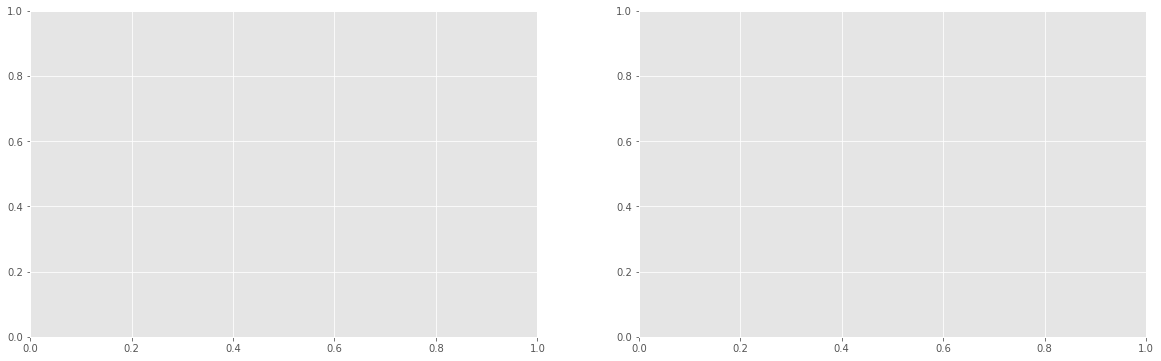

In [7]:
speeds = cda.remove_unrealistic_speeds(p_df, 3, notebook = True)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
print(np.amax(speeds), len(speeds), speeds[:20])
ax = plt.hist(speeds)
ax.set_title("Users' Average Speeds")
ax.set_xlabel('Speed' + r'($ms^{-1}$)')
ax.set_ylabel('Count of shoppers (no.)')

p_df = cda.remove_unrealistic_speeds(p_df, 3)
speeds = cda.remove_unrealistic_speeds(p_df, 3, notebook = True)

ax = plt.hist(speeds)
ax.set_title("Users' Average Speeds")
ax.set_xlabel('Speed' + r'($ms^{-1}$)')
ax.set_ylabel('Count of shoppers (no.)')

## Sparse Data

Another functionality we introduce into our cleaning module is the ability to remove mac addresses for which there are not many data points. 1 or even 2 data points for a given person tell us nothing about the movement profile of the individual, let alone the macroscopic data attributes. For initial purposes, we set a threshold of 10 data points for each mac ID.

In [61]:
p_df = cda.remove_sparse_data(p_df, 10)

## Outstanding Issues

- Data points from outside the physical confines of the mall: Plots of the data show that there are relatively few points that fit into this category, but ideally we want to remove them either way. For this we will need information of the mall schematics.
- Stationary IDs: Store clerks, security guards etc. may spend lots of time in one place and are not really of interest to us. These should be removed
- There still appear to be inherrent errors in the dataset that we may not be able to do anything about. Above it seems that there may have been a fault in the harvesting equipment at around 1pm. This, or there is a causal link between the time and the reduction of counts e.g. lunchtime? 
- In the first histogram above, which includes the data that we nominally classified as corresponding to errant background, appears to be bimodal. When we trim the mac addresses, the second mode disappears and we are left with a distribution resembling a less skewed normal distribution. Naively, this leads us to believe that the data corresponding to out of hour signals is not a systematic background noise but itself has a distribution. It would be instructive to look at the profile of the data that we are discarding (this case in particular but also in general); this will only aid our understanding of the overall data set we are working with.